# Importing libs

In [2]:
import os
import tarfile
import random
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image

# Globals

In [3]:
PATH = os.path.join('..', 'dataset')
BATCH_SIZE = 32
EPOCHS = 20

# Preprocessing

In [4]:
arch = tarfile.open(os.path.join( PATH, 'crop_part1.tar.gz'), 'r')
arch.getnames()[:3]

['crop_part1/24_1_2_20170104020224692.jpg.chip.jpg',
 'crop_part1/3_1_3_20161219230106056.jpg.chip.jpg',
 'crop_part1/35_0_0_20170105162448427.jpg.chip.jpg']

In [5]:
landmarks_df = pd.read_csv(os.path.join(PATH, 'landmark_list_part1.txt'), sep= ' ', header= None)
landmarks_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,1_0_2_20161219140530307.jpg,-4,71,-4,96,-3,120,-1,144,9,...,136,130,135,108,139,98,140,88,139,NaN
1,1_0_2_20161219140525218.jpg,13,76,13,96,15,117,18,137,25,...,137,121,141,102,141,94,142,85,143,NaN
2,1_0_2_20161219140540938.jpg,11,62,14,84,18,105,23,127,33,...,135,135,136,109,147,99,148,90,146,NaN


In [6]:
landmarks_df = landmarks_df.drop(columns= [137])

In [7]:
file_names = []
for name in arch.getnames():
    name = name.replace('crop_part1/', '')
    name = name.replace('.chip.jpg', '')
    file_names.append(name)
file_names[:3]

['24_1_2_20170104020224692.jpg',
 '3_1_3_20161219230106056.jpg',
 '35_0_0_20170105162448427.jpg']

In [8]:
for name in file_names:
    if name not in landmarks_df[0].values:
        print(name)

crop_part1


In [9]:
file_names.remove('crop_part1')

In [10]:
len(file_names)

9780

In [11]:
landmarks_df[landmarks_df[0] == '24_1_2_20170104020224692.jpg'].values[0][1:][:5]

array([14, 48, 15, 70, 18], dtype=object)

## Collect neccesarry metrics (mean, std)

In [12]:
np_imgs = []
for f_name in arch.getnames():
    try:
        img = arch.extractfile(f_name)
        img = Image.open(img)
        img = np.asarray(img)
        np_imgs.append(img)
    except:
        print(type(img))

<class 'NoneType'>


In [13]:
np_imgs = np.array(np_imgs)
np_imgs.shape

(9780, 200, 200, 3)

In [14]:
# uncomment for long calcs
#print(f'Mean: {np_imgs.mean()}, Std: {np_imgs.std()}')

## FacesDataset

In [51]:
class UTKFacesDataset:
    def __init__(self, 
                 mode, 
                 array, 
                 landmarks_df, 
                 mean, std, 
                 transforms = None):
        self.mode = mode
        self.imgarr = copy.deepcopy(array)
        self.labels = copy.deepcopy(landmarks_df)
        self.mean = mean
        self.std = std
        self.transforms = transforms

    def __len__(self):
        return len(self.imgarr)

    def __getitem__(self,idx):
        x = self.imgarr[idx]
        x = arch.extractfile(x)
        if x is not None:
            x = Image.open(x)
            x = self.augment(x)

            f_name = self.imgarr[idx]
            f_name = f_name.replace('crop_part1/', '')
            f_name = f_name.replace('.chip.jpg', '')

            y = landmarks_df[landmarks_df[0] == f_name].values[0][1:]
            y = np.array(y, dtype= np.int32)
            return x, y
        else:
            x = self.imgarr[idx - 1]
            x = arch.extractfile(x)

            x = Image.open(x)
            x = self.augment(x)

            f_name = self.imgarr[idx]
            f_name = f_name.replace('crop_part1/', '')
            f_name = f_name.replace('.chip.jpg', '')

            y = landmarks_df[landmarks_df[0] == f_name].values[0][1:]
            y = np.array(y, dtype= np.int32)
            return x, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()
    
    def normalize(self, x):
        return tf.image.per_image_standardization(x)
            
    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        reidx = random.sample(population = list(range(self.__len__())),k = self.__len__())
        self.imgarr = self.imgarr[reidx]
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, x):
        if self.transforms is not None:
            x = self.transforms(x)
        x = self.normalize(x)
        return x

In [52]:
datagen = UTKFacesDataset('train', arch.getnames(), landmarks_df,  mean= 131.10, std= 63.88)

In [53]:
out_shape = (tf.TensorShape([200, 200, 3]), tf.TensorShape([136]))
out_type = (tf.float32, tf.float32)

dataset = tf.data.Dataset.from_generator(datagen, output_shapes= out_shape, output_types= out_type)
dataset = dataset.batch(BATCH_SIZE)

In [54]:
#for batch in dataset:
#    x,y = batch
#   | Training step |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


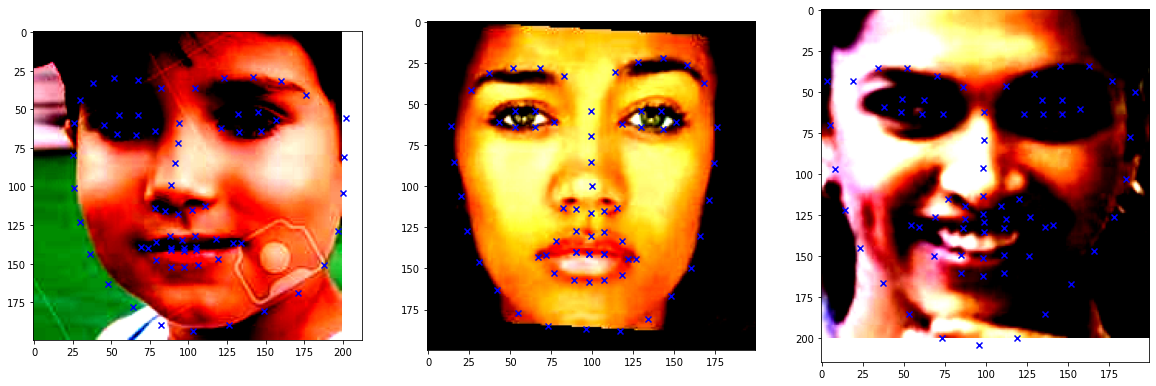

In [55]:
# show some samples
fig, axs = plt.subplots(1, 3, figsize= (20, 12))

counter = 0
for batch in dataset:
    x, y = batch
    x, y = x[3:6], y[3:6]
    for i in range(0,3):
        axs[i].imshow(x[i])
        y_resh = tf.reshape(y[i],[68, 2])
        axs[i].scatter(*zip(*y_resh), marker= 'x', color= 'b')
    counter +=1
    if counter == 1:
        break



# Model

In [40]:
cnn_v1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (200,200,3)),

    # conv1
    tf.keras.layers.Resizing(150, 150),
    tf.keras.layers.Conv2D(10, (5,5), padding= 'same', activation= 'relu', input_shape= (150,150,3)),
    tf.keras.layers.MaxPool2D((2,2), strides= 2),
    tf.keras.layers.BatchNormalization(input_shape= (73, 73, 10)),

    # conv2
    tf.keras.layers.Conv2D(12, (3,3), padding= 'same', activation= 'relu', input_shape= (73,73, 10)),
    tf.keras.layers.MaxPool2D((2,2), strides= 2),
    tf.keras.layers.BatchNormalization(input_shape= (35,35,12)),

    # fc
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(136, activation="relu")
])


In [41]:
cnn_v1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 150, 150, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 150, 150, 10)      760       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 10)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 75, 75, 10)       40        
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 12)        1092      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 37, 37, 12)      

In [56]:
tf.keras.utils.plot_model(
    cnn_v1,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [57]:
cnn_v1.compile(optimizer='adam',
              loss=tf.keras.losses.MSE,
              metrics=['accuracy'])

In [58]:
cnn_v1.fit(dataset, epochs= EPOCHS)

Epoch 1/20
    227/Unknown - 68s 299ms/step - loss: 189.8338 - accuracy: 0.2976

InvalidArgumentError: Graph execution error:

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32), but the yielded element was None.
Traceback (most recent call last):

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1036, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\tensorflow\python\data\util\nest.py", line 379, in flatten_up_to
    assert_shallow_structure(shallow_tree, input_tree)

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\tensorflow\python\data\util\nest.py", line 280, in assert_shallow_structure
    raise TypeError(

TypeError: If shallow structure is a sequence, input must also be a sequence. Input has type: 'NoneType'.


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1038, in generator_py_func
    six.reraise(

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\six.py", line 718, in reraise
    raise value.with_traceback(tb)

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1036, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\tensorflow\python\data\util\nest.py", line 379, in flatten_up_to
    assert_shallow_structure(shallow_tree, input_tree)

  File "d:\Projects\Python\Faces_UTK\.venv\lib\site-packages\tensorflow\python\data\util\nest.py", line 280, in assert_shallow_structure
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32), but the yielded element was None.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_346019]